In [3]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely as shp
import rasterio as rio 
from rasterio.plot import show
from skimage.filters import threshold_otsu
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Directories
data_dir = os.path.join(os.getcwd(),"data") # path to data-folder with aux data
plot_dir = os.path.join(os.getcwd(),"figures/plots")
proc_tiles_path = os.path.join(os.path.join(data_dir,"VN_processing_polygons")) # path to processing tiles
country_bounds_path = os.path.join(data_dir,"VN_country_bounds") # path to country bounds
osm_sl_path = os.path.join(os.path.join(data_dir,"VN_osm_coastline")) # path to reference shoreline
buffer_path = os.path.join(os.path.join(data_dir,"VN_buffer_5km"))

# Params
crs = "EPSG:3857"

# global Plotting params
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["font.size"] = 11
coastal_blue = "#074e67"
coastal_turquoise = "#05878a"
coastal_beige = "#b6af9d"
coastal_orange = "#ff8f7a"
coastal_grey = "#d7ccc8"

In [5]:
# read/ create aux data 
proc_tiles = gpd.read_file(proc_tiles_path).to_crs(crs)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


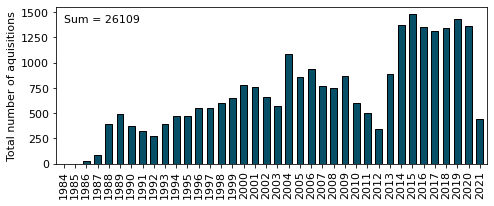

In [4]:
# Number of images used for processing coastlines of entire Vietnam from 1984-May 2
noa_list = []
for i in proc_tiles.id:
    tile_name = "P"+str(i).zfill(2) # name of processing tile
    folder_path = os.path.join(data_dir,tile_name) # path to mndwi rasters and meta
    meta_path = os.path.join(data_dir,tile_name,tile_name+".csv")
    meta = pd.read_csv(meta_path)
    meta = meta.drop(columns=['system:index','.geo'])
    meta = meta.transpose().rename(columns={0:"NOA"})
    meta['year'] = meta.index
    meta = meta.reset_index(drop=True)
    noa_list.append(meta)

noa_dict = {key:[] for key in range(1984,2022)}
for df in noa_list:
    years = list(df.year)
    for year in years:
        try:
            count = df.loc[np.where(np.array(years)==year)[0][0],"NOA"]
        except IndexError:
            count=0
        noa_dict[int(year)].append(count)

for year in noa_dict:
    noa_dict[year] = np.sum(noa_dict[year])

noa_df = pd.DataFrame(data=noa_dict.values(),index=noa_dict.keys())
noa_df = noa_df.rename(columns={0:"NOA"})

# plot
fig, ax = plt.subplots(figsize=(7, 3))
#fig, axes = plt.subplots(2, 3, figsize=(6, 5))
ax.bar(x=noa_df.index, height=noa_df["NOA"], color=coastal_blue, edgecolor="black", width=0.6)
ax.set_xticks(noa_df.index)
ax.margins(x=0.01)
ax.set_xticklabels(noa_df.index, rotation=90)
ax.set_ylabel("Total number of aquisitions")
ax.text(1984,1400,"Sum = "+str(int(np.sum(noa_df.NOA))))
fig.tight_layout()
fig.savefig(os.path.join(plot_dir,"Landsat_aquisitions"), dpi=150)
#plt.close(fig)

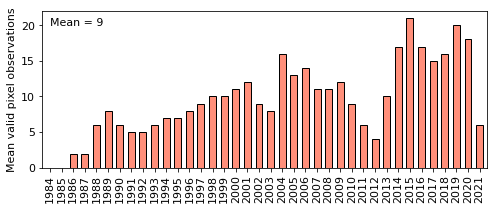

In [5]:
# Average number of pixel observations per year 
nvo_dict = {key:[] for key in range(1984,2022)}

for i in proc_tiles.id:
    tile_name = "P"+str(i).zfill(2) # name of processing tile
    folder_path = os.path.join(data_dir,tile_name) # path to mndwi rasters and meta
    files = glob.glob(os.path.join(folder_path,"*aq.tif"))
    for file in files:
        year = int(os.path.basename(file)[4:8])
        aq = int(os.path.basename(file)[9:11])
        nvo_dict[int(year)].append(aq)

for year in nvo_dict:
    if len(nvo_dict[year])==0: nvo_dict[year]=0
    nvo_dict[year] = np.mean(nvo_dict[year])

nvo_df = pd.DataFrame(data=nvo_dict.values(),index=nvo_dict.keys())
nvo_df = nvo_df.rename(columns={0:"NVO"})
nvo_df.NVO = nvo_df.NVO.round(0).astype(int)

# plot
fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(x=nvo_df.index, height=nvo_df["NVO"], color=coastal_orange, edgecolor="black", width=0.6)
ax.set_xticks(nvo_df.index)
ax.margins(x=0.01)
ax.set_xticklabels(nvo_df.index, rotation=90)
ax.set_ylabel("Mean valid pixel observations")
ax.text(1984,20,"Mean = "+str(int(np.mean(nvo_df.NVO))))
fig.tight_layout()
fig.savefig(os.path.join(plot_dir,"Avg_pixel_observations"), dpi=150)
#plt.close(fig)

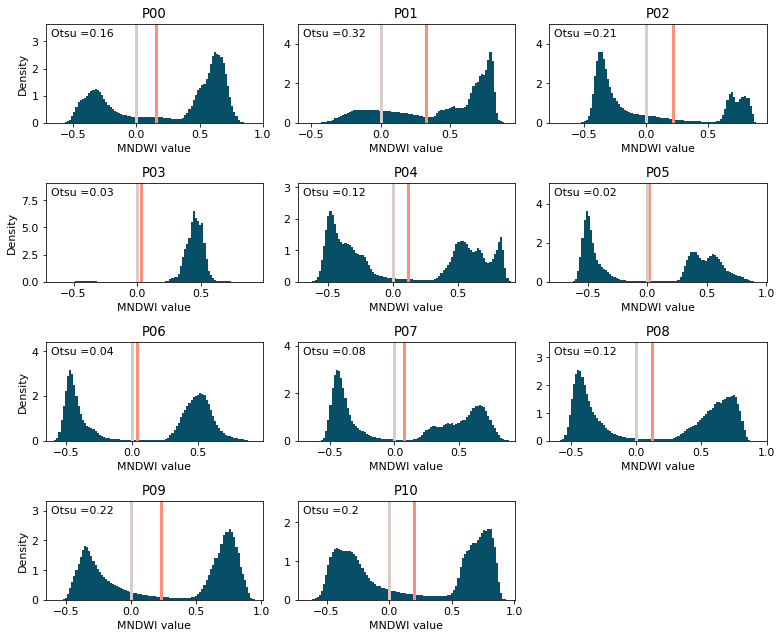

In [94]:
# Plot the Otsu thresholds of all processing tiles for 2015 (year with most valid observations)
from scipy import stats
fig, axes = plt.subplots(4, 3, figsize=(11, 9))
fig.delaxes(axes[3,2])
for i, ax in zip(proc_tiles.id, axes.flatten()):
    tile_name = "P"+str(i).zfill(2) # name of processing tile
    folder_path = os.path.join(data_dir,tile_name) # path to mndwi rasters and meta
    raster_files = glob.glob(os.path.join(folder_path,"*2015*aq.tif"))
    for r in raster_files:
        year = os.path.basename(r)[4:8]
        with rio.open(r,"r") as raster:
            image = raster.read(1)
            if np.count_nonzero(image) > 0 and np.count_nonzero(~np.isnan(image)) > 0:
                thresh = threshold_otsu(image[~np.isnan(image)])
                ax.hist(image.ravel(),bins=100,color=coastal_blue,density=True)
                ax.axvline(thresh, color=coastal_orange,lw=3)
                ax.axvline(0,color=coastal_grey,lw=3)
                ax.margins(x=0.01,y=0.4)
                ax.annotate("Otsu ="+str(thresh.round(2)),xy=(0,1),xycoords="axes fraction",xytext=(5,-5), textcoords="offset points",ha="left",va="top")
                if (i % 3) == 0:
                    ax.set_ylabel("Density")
                ax.set_xlabel("MNDWI value")
                ax.set_title(tile_name)
fig.tight_layout()
fig.savefig(os.path.join(plot_dir,"Otsus_"+year), dpi=600)

Text(5, -5, 'Mean =0.19')

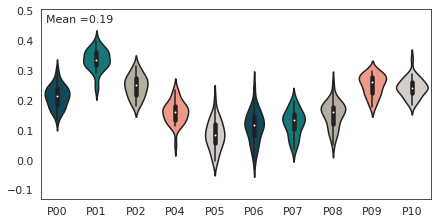

In [144]:
# plot the distribution of all otsu thresholds 
otsu_dict = {key:[] for key in range(0,10)}
for i in proc_tiles.id:
    tile_name = "P"+str(i).zfill(2) # name of processing tile
    folder_path = os.path.join(data_dir,tile_name) # path to mndwi rasters and meta
    sl_files = glob.glob(os.path.join(folder_path,tile_name+"_shorelines"))
    for file in sl_files:
        sl = gpd.read_file(file)
        otsu_dict[i] = list(sl.otsu_thres)

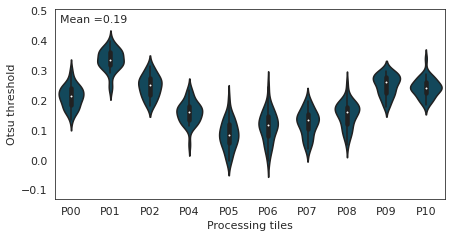

In [150]:
# plot
sns.set_style('white')

otsu_lists = list(otsu_dict.values())
del otsu_lists[3]
otsus_flat = [y for x in otsu_lists for y in x]
otsus_flat = [float(item) for item in otsus_flat]
otsu_mean = np.mean(otsus_flat)

x_labels = ["P00","P01","P02","P04","P05","P06","P07","P08","P09","P10"]
coastal_colors = [coastal_blue,coastal_turquoise,coastal_beige,coastal_orange,coastal_grey]

fig,ax = plt.subplots(figsize=(7, 3.5))
sns.violinplot(data=otsu_lists, color=coastal_blue) #palette=coastal_colors
ax.set_xticklabels(x_labels)
ax.margins(x=0.01,y=0.15)
ax.set_ylabel("Otsu threshold")
ax.set_xlabel("Processing tiles")
ax.annotate("Mean ="+str(otsu_mean.round(2)),xy=(0,1),xycoords="axes fraction",xytext=(5,-5), textcoords="offset points",ha="left",va="top")
fig.savefig(os.path.join(plot_dir,"Otsus_mean"), dpi=300)